# import DATA

In [20]:
import pandas as pd
df = pd.read_csv("export-4EAAECB6B0E6-1d.csv")

# explore data

In [21]:
df

,Unnamed: 0,timestamp,timezone,humidity,pm_10,pm_2_5,temperature
0,0,2021-02-12 07:00:00,Asia/Bangkok,75.649816,10.664621,9.994301,30.064280
1,1,2021-02-13 07:00:00,Asia/Bangkok,76.406306,12.754405,11.959367,29.913876
2,2,2021-02-14 07:00:00,Asia/Bangkok,73.215672,25.340778,22.967928,29.838483
3,3,2021-02-15 07:00:00,Asia/Bangkok,73.824182,29.525503,26.964068,29.339262
4,4,2021-02-16 07:00:00,Asia/Bangkok,73.115549,37.257092,32.659490,29.252021
...,...,...,...,...,...,...,...
1447,1447,2025-02-01 07:00:00,Asia/Bangkok,76.430363,37.186263,32.588143,27.837237
1448,1448,2025-02-02 07:00:00,Asia/Bangkok,74.367852,39.424689,34.765290,28.596695
1449,1449,2025-02-03 07:00:00,Asia/Bangkok,73.734409,30.725657,27.210047,28.272388
1450,1450,2025-02-04 07:00:00,Asia/Bangkok,73.405211,21.746457,20.148828,29.616789


In [22]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1452 entries, 0 to 1451
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1452 non-null   int64  
 1   timestamp    1452 non-null   object 
 2   timezone     1452 non-null   object 
 3   humidity     1452 non-null   float64
 4   pm_10        1452 non-null   float64
 5   pm_2_5       1452 non-null   float64
 6   temperature  1452 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 79.5+ KB


Unnamed: 0     0
timestamp      0
timezone       0
humidity       0
pm_10          0
pm_2_5         0
temperature    0
dtype: int64

In [23]:
df.boxplot()

<Axes: >

In [24]:
print(f'Max of data : \n{df.max()}\n')
print(f'Min of data : \n{df.min()}')

Max of data : 
Unnamed: 0                    1451
timestamp      2025-02-05 07:00:00
timezone              Asia/Bangkok
humidity                 99.066657
pm_10                    76.125854
pm_2_5                   65.845075
temperature              33.417457
dtype: object

Min of data : 
Unnamed: 0                       0
timestamp      2021-02-12 07:00:00
timezone              Asia/Bangkok
humidity                 68.309056
pm_10                     1.887649
pm_2_5                    1.548794
temperature              24.678445
dtype: object


# Clean DATA

In [25]:
# Clean Data
# แปลง timestamp เป็น datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [26]:
# ลบคอลัมน์ที่ไม่จำเป็น
df.drop(columns=["Unnamed: 0", "timezone"], inplace=True)

In [27]:
# เรียงลำดับตามเวลา
df.sort_values("timestamp", inplace=True)

In [28]:
# รีเซ็ต index
df.reset_index(drop=True, inplace=True)

# Feature Engineering

In [29]:
# Feature Engineering
# สร้าง Lag Features (ค่า PM 2.5 ย้อนหลัง 1-7 วัน)
for lag in range(1, 8):
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag)

In [30]:
# สร้าง Moving Average (ค่าเฉลี่ยเคลื่อนที่ 3 วัน และ 7 วัน)
df["pm_2_5_ma3"] = df["pm_2_5"].rolling(window=3).mean()
df["pm_2_5_ma7"] = df["pm_2_5"].rolling(window=7).mean()

In [31]:
# สร้างฟีเจอร์ทางเวลา
df["day_of_week"] = df["timestamp"].dt.dayofweek  # 0 = Monday, 6 = Sunday
df["month"] = df["timestamp"].dt.month

In [32]:
# ลบแถวที่มีค่า NaN (เกิดจากการ shift และ rolling average)
df.dropna(inplace=True)

In [33]:
# เลือก features
target = "pm_2_5"
features = [col for col in df.columns if col not in ["timestamp", target]]

In [34]:
# แบ่ง train/test set
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, shuffle=False, random_state=42)
# ✅ ตรวจสอบขนาดของชุดข้อมูล
print("Train set:", train_df.shape)
print("Test set:", test_df.shape)

Train set: (1156, 16)
Test set: (289, 16)


# Train Model

In [35]:
from pycaret.regression import *

In [ ]:
#  ตั้งค่าการทดลอง PyCaret
exp = setup(
    data=train_df,
    target="pm_2_5",
    session_id=42,
    fold=10,  # Cross-validation 5 folds
    feature_selection=features,
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 924, number of used features: 15
[LightGBM] [Info] Start training from score 14.129263


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(1156, 16)"
4,Transformed data shape,"(1156, 4)"
5,Transformed train set shape,"(924, 4)"
6,Transformed test set shape,"(232, 4)"
7,Numeric features,14
8,Date features,1
9,Preprocess,True


In [37]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.2017,0.1136,0.3305,0.9984,0.0182,0.0148,0.1540
gbr,Gradient Boosting Regressor,0.2004,0.1123,0.3322,0.9984,0.0178,0.0147,0.1440
rf,Random Forest Regressor,0.2054,0.1333,0.3573,0.9982,0.0179,0.0146,0.1900
dt,Decision Tree Regressor,0.2534,0.1818,0.4225,0.9974,0.0223,0.0181,0.1040
lr,Linear Regression,0.4241,0.3560,0.5938,0.9949,0.0513,0.0418,2.0180
ridge,Ridge Regression,0.4277,0.3564,0.5941,0.9949,0.0521,0.0424,0.1100
lar,Least Angle Regression,0.4241,0.3560,0.5938,0.9949,0.0513,0.0418,0.1360
br,Bayesian Ridge,0.4242,0.3560,0.5938,0.9949,0.0513,0.0418,0.0980
omp,Orthogonal Matching Pursuit,0.4352,0.3674,0.6043,0.9948,0.0531,0.0432,0.1060
ada,AdaBoost Regressor,0.5515,0.5437,0.7356,0.9923,0.0950,0.0680,0.1560


In [38]:
# เทรนโมเดลที่ดีที่สุด
final_model = finalize_model(best_model)

In [39]:
# ทำนายค่าฝุ่น PM 2.5 ใน test set
predictions = predict_model(final_model, data=test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2220,0.1141,0.3378,0.9986,0.0194,0.0158


In [40]:
predictions[["timestamp", "pm_2_5", "prediction_label"]]  # Label คือค่าพยากรณ์

,timestamp,pm_2_5,prediction_label
1163,2024-04-20 07:00:00,21.370852,21.032826
1164,2024-04-21 07:00:00,26.985611,26.225907
1165,2024-04-22 07:00:00,28.640259,29.071525
1166,2024-04-23 07:00:00,29.490662,29.515505
1167,2024-04-24 07:00:00,26.994606,27.700863
...,...,...,...
1447,2025-02-01 07:00:00,32.588142,32.375268
1448,2025-02-02 07:00:00,34.765289,33.806830
1449,2025-02-03 07:00:00,27.210047,27.759084
1450,2025-02-04 07:00:00,20.148829,19.961407


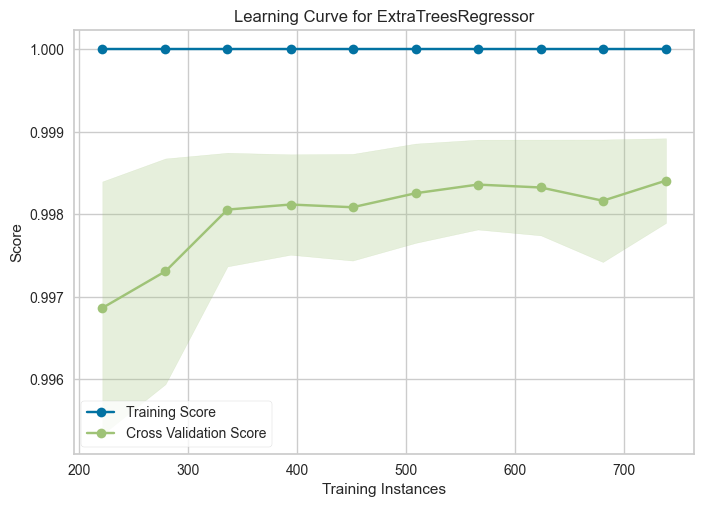

In [42]:
# Plot learning curve เพื่อตรวจสอบ overfitting
plot_model(final_model, plot="learning")